In [1]:
import os, sys
import sys
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import mutagen
sys.path.append('..')

%matplotlib inline
np.version.version

'1.17.0'

In [2]:
file_name = '../02 Vamos Acabar Com o Baile.m4a'
audiopath = os.path.join(file_name)
metadata = mutagen.File(file_name, easy=True)
metadata

{'title': ['Vamos Acabar Com o Baile'], 'album': ['Vamos Acabar Com o Baile: A Música de Garoto por Henrique Cazes & Marcello Gonçalves'], 'artist': ['Henrique Cazes, Marcello Gonçalves'], 'albumartist': ['Henrique Cazes, Marcello Gonçalves'], 'date': ['2007-10-04T07:00:00Z'], 'genre': ['Choro'], 'copyright': ['℗ 2007 Deckdisc'], 'albumsort': ['Vamos Acabar Com o Baile: A Música de Garoto por Henrique Cazes & Marcello Gonçalves'], 'artistsort': ['Henrique Cazes, Marcello Gonçalves'], 'titlesort': ['Vamos Acabar Com o Baile'], 'tracknumber': ['2/13'], 'discnumber': ['1/1']}

In [3]:
x, Fs = librosa.load(audiopath, mono=True, sr=44100, duration = 0.82)
print('')
print('The signal x has %d samples and a duration of %.2f seconds.' % (len(x), len(x) / Fs))
print('sampling rate = %d Hz' % (Fs))
ipd.Audio(x, rate=Fs)


The signal x has 36162 samples and a duration of 0.82 seconds.
sampling rate = 44100 Hz


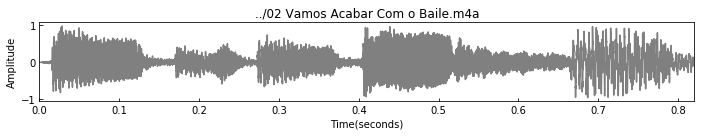

In [4]:
def cartesian_plot_R2(x_values, title, x_label, y_label, sr):
    t = np.arange(x_values.shape[0]) / sr
    plt.figure(figsize=(10, 2))
    plt.plot(t, x_values, color='gray')
    plt.xlabel(x_label)
    if y_label!=None:
        plt.ylabel(y_label)
    if title!=None:
        plt.title(title)
    plt.xlim([t[0], t[-1]])
    plt.tick_params(direction='in')
    plt.tight_layout()
    return;
cartesian_plot_R2(x_values=x, title=metadata.filename, x_label='Time(seconds)', y_label='Amplitude', sr = Fs)

In [5]:
def spectrogram_plot(x, fs, gamma=0, N=2048, H=128, ylim_top = 1750, ylim_bottom = 0):
    #size n, hop size h
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Y = np.abs(X)
    if gamma == 0:
        amplitude = librosa.amplitude_to_db(Y, ref=np.max)
    else:
        amplitude = np.log(1 + gamma * np.abs(X))
        amplitude = amplitude / np.amax(amplitude)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(amplitude, 
                         y_axis='linear', x_axis='time', sr=fs, hop_length=H, cmap='gray_r')
    if gamma == 0:
        plt.colorbar(format='%+2.0f dB')
        plt.title('STFT: N = ' +str(N) + ', H = ' + str(H))
    else:
        plt.colorbar(format='%+2.0f')
        plt.title('STFT: N = ' +str(N) + ', H = ' + str(H) + ', gamma = ' + str(gamma))

    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.ylim(ylim_bottom, ylim_top)
    return;

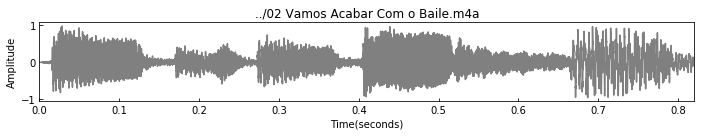

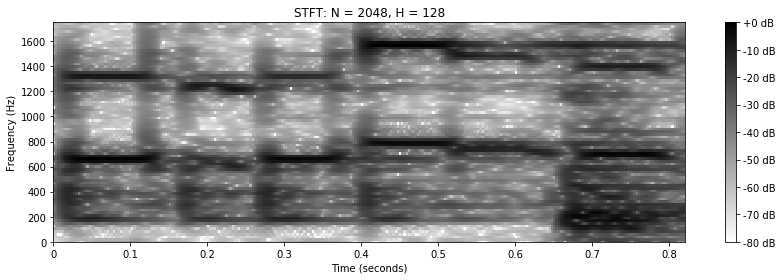

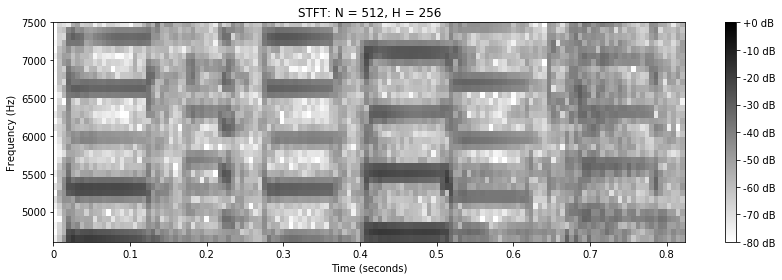

In [6]:
cartesian_plot_R2(x_values=x, title=metadata.filename, x_label='Time(seconds)', y_label='Amplitude', sr = Fs)
spectrogram_plot(x, fs=Fs)
spectrogram_plot(x, fs=Fs, N = 512, H = 256, ylim_top = 7500, ylim_bottom = 4600 )

# Energy Based Novelty:

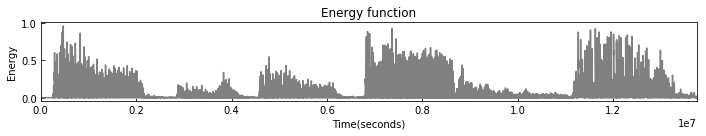

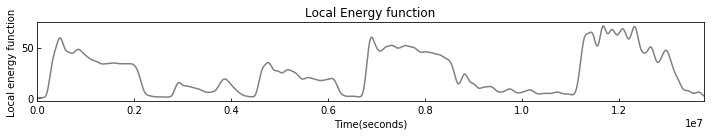

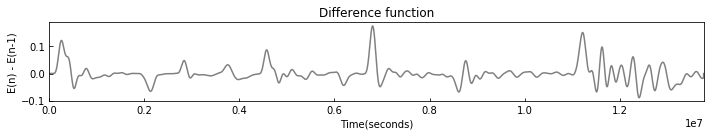

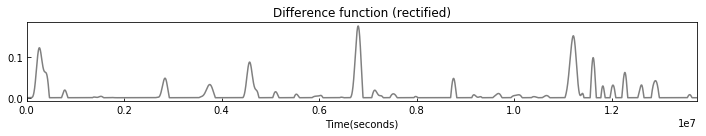

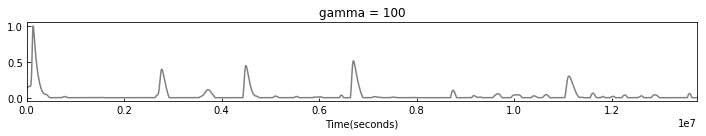

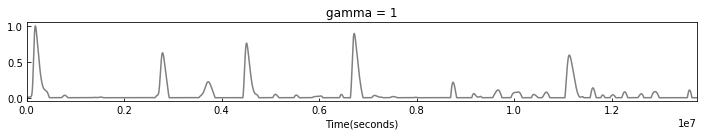

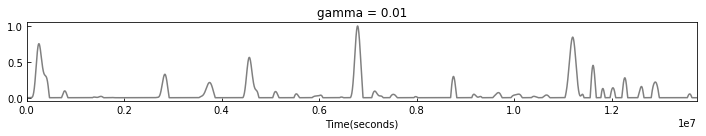

In [22]:
cartesian_plot_R2(x_values=x**2, title='Energy function',x_label='Time(seconds)', y_label='Energy', sr = Fs)
H = 1024
w = signal.hann(H)
energy_local = np.convolve(x**2, w**2, 'same')
#energy_local = energy_local[::H]

cartesian_plot_R2(energy_local, title='Local Energy function', x_label='Time(seconds)', y_label='Local energy function', sr = Fs)

energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
cartesian_plot_R2(energy_local_diff, title='Difference function', x_label='Time(seconds)', y_label='E(n) - E(n-1)', sr = Fs)

novelty_energy = np.copy(energy_local_diff)
novelty_energy[energy_local_diff < 0] = 0
cartesian_plot_R2(novelty_energy, title='Difference function (rectified)', x_label='Time(seconds)', y_label='', sr = Fs)

def plot_diff(energy_local, gamma = 1):
    log_energy_local_diff = np.diff(np.log(1 + gamma * energy_local))
    log_energy_local_diff = np.concatenate((log_energy_local_diff, np.array([0])))
    novelty_log_energy = np.copy(log_energy_local_diff)
    novelty_log_energy[energy_local_diff < 0] = 0
    novelty_log_energy = novelty_log_energy / max(novelty_log_energy)
    cartesian_plot_R2(novelty_log_energy, title= 'gamma = ' + str(gamma) , x_label='Time(seconds)', y_label='', sr = Fs)
    return;
    
plot_diff_log(energy_local=energy_local, gamma = 100)
plot_diff_log(energy_local=energy_local, gamma = 1)
plot_diff_log(energy_local=energy_local, gamma = 0.01)





# Spectral Based Novelty:

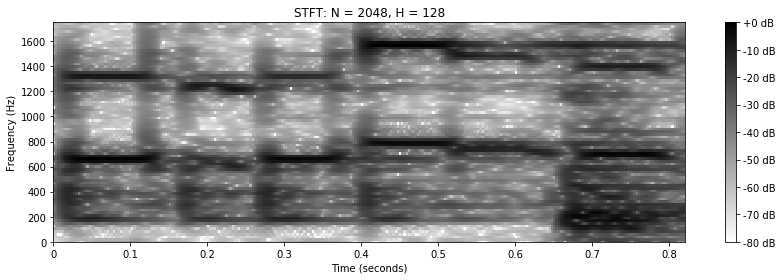

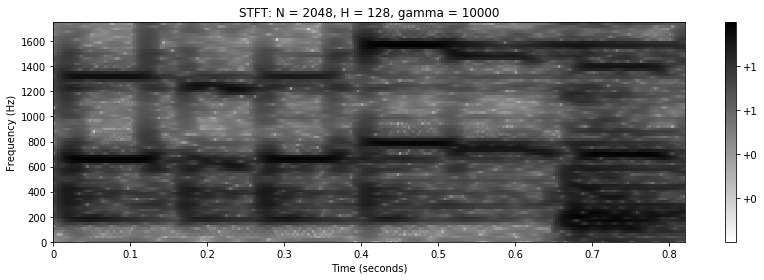

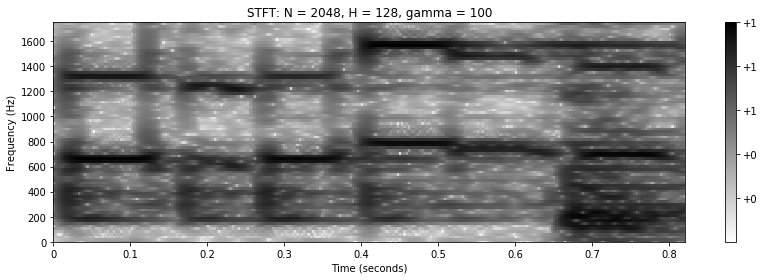

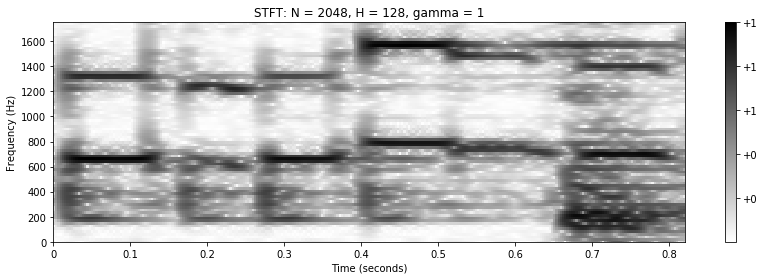

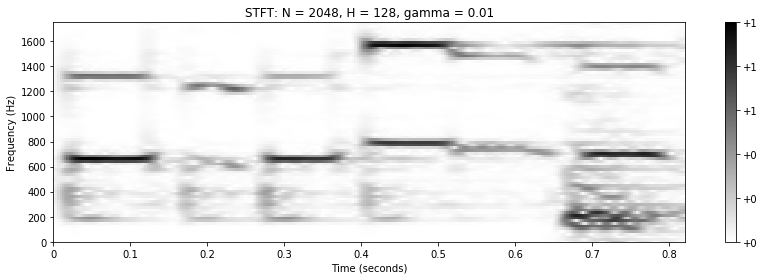

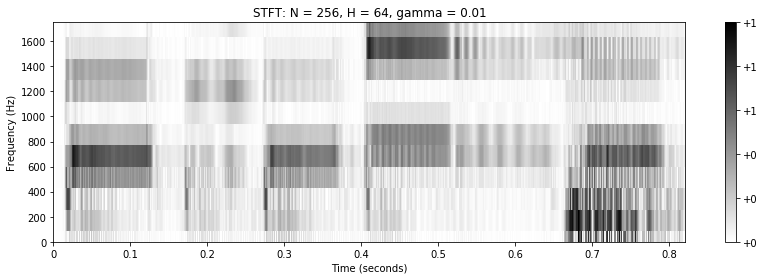

In [8]:
spectrogram_plot(x, fs=Fs)
spectrogram_plot(x, fs=Fs, gamma = 10000)
spectrogram_plot(x, fs=Fs, gamma = 100)
spectrogram_plot(x, fs=Fs, gamma = 1)
spectrogram_plot(x, fs=Fs, gamma = 0.01)
spectrogram_plot(x, fs=Fs, gamma = 0.01, N = 256, H=64)


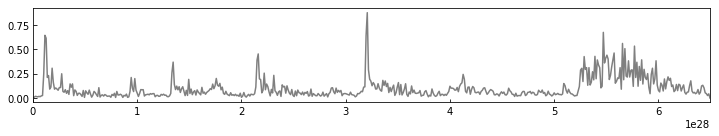

In [32]:
gamma = 0.01
N, H = 256, 64
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')

Y = np.log(1 + gamma * np.abs(X))
Y_diff = np.diff(Y, n=1)
Y_diff[Y_diff < 0] = 0
nov = np.sum(Y_diff, axis=0)
nov = np.concatenate((nov, np.array([0])))
Fs_nov = Fs=Fs/H

cartesian_plot_R2(nov, title = '', x_label = '', y_label = '', sr = Fs)

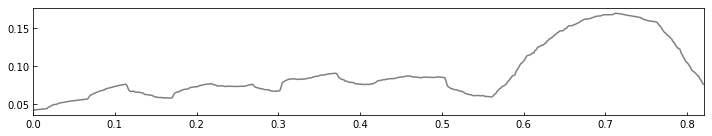

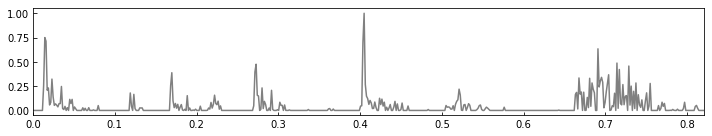

In [10]:
def get_local_average(x, M):
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
            a = np.max([m-M,0])
            b = np.min([m+M+1,L])
            local_average[m] =(1/(2*M+1))*np.sum(x[a:b])
    return local_average;

M_sec = 0.1
M = int(np.ceil(M_sec*Fs_nov))

local_average = get_local_average(nov, M)
nov_norm =  nov - local_average
nov_norm[nov_norm<0]=0
nov_norm = nov_norm / max(nov_norm)

cartesian_plot_R2(local_average, title = '', x_label = '', y_label = '', sr = Fs)
cartesian_plot_R2(nov_norm, title = '', x_label = '', y_label = '', sr = Fs)    